In [1]:
"""
Created on Tue Ago 03 15:14:57 2021

@author: Alejandro Lopez
"""

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import pysal
import os
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.ops import cascaded_union
from shapely.geometry import Point, LineString, Polygon
from geovoronoi import voronoi_regions_from_coords
from pysal.explore import esda
from pysal.lib import weights
from matplotlib import colors
import plotly.graph_objs as go
import chart_studio.plotly as py
import shapely
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import shap
from joblib import dump,load
from sklearn.metrics import confusion_matrix

C:\ProgramData\Anaconda3\envs\sqdm\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\ProgramData\Anaconda3\envs\sqdm\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# script modo Ejecucion

In [2]:
modo_ejecucion='predicion' #  predicion / entrenamiento

In [3]:
####Definición de rutas#####
#os.chdir('D:\CLARO\GEOESPACIAL')  C:\\Users\WilsonAdolfoEstacioR\\Documents\
# os.chdir('D:\Gestion\Proyectos\GeoEspacial')
os.chdir('D:\\Will_Analisis\\')
analysis_dir = os.getcwd()
analisis_dir = os.getcwd()
data_cob_mayo=os.path.join(analisis_dir, 'Datos\\Shapefiles\\COBERTURAS_UNIFICADAS\\')
data_geojson = os.path.join(analisis_dir, 'Expansion_Fija\\Insumos\\Shapefiles') # C:\Users\WilsonAdolfoEstacioR\Documents\Expansion_Fija\Insumos\Shapefiles
data_dir= os.path.join(analisis_dir,'Expansion_Fija\\1_Datos\\') #\\Camacol
# C:\Users\WilsonAdolfoEstacioR\Documents\Expansion_Fija\1_Datos\INFO_NUEVA
result_dir= os.path.join(analisis_dir,'Expansion_Fija\\3_Resultados\\') # C:\Users\WilsonAdolfoEstacioR\Documents\Expansion_Fija\3_Resultados
# data_dir = os.path.join(analysis_dir, 'Expansion_Fija\1_Datos')
# result_dir = os.path.join(analysis_dir, 'Expansion_Fija\\3_Resultados')

In [4]:
# 	GID	DPTO_CCDGO	MPIO_CCDGO	MPIO_CNMBR	MPIO_CCNCT	DPTO_CNMBR	DTH_MPIO	NODO	FTTH_NODO	geometry
# categori_columna_x=HFC.Tipo.unique()
# categori_columna_x

In [70]:
####Lectura de datos####
HFC=gpd.read_file(os.path.join(data_cob_mayo, "MAYO\\COBERTURA_UNIF_MAYO.shp"))
# HFC=gpd.read_file(os.path.join(analysis_dir, "Insumos\\Shapefiles\\COBERTURA_UNIF_MARZO.shp"))
# HFC=gpd.read_file(os.path.join(analysis_dir, "Insumos\\Shapefiles\\COBERTURA_UNIF_MARZO.shp"))
HFC=HFC.loc[HFC.geometry.is_valid]
##HFC=HFC.drop_duplicates("NODO")
HFC=HFC.drop_duplicates("HFC_NODO")
HFC=HFC.reset_index(drop=True)
##Adicione esta instruccion para cambiar el nombre a la columna HFC_NODO
# HFC.rename(columns={'HFC_NODO':'NODO'},inplace=True)
HFC.rename(columns={'mpio_ccnct':'MPIO_CCNCT'},inplace=True)
HFC.rename(columns={'mpio_cnmbr':'MPIO_CNMBR'},inplace=True)
HFC.rename(columns={'dpto_cnmbr':'DPTO_CNMBR'},inplace=True)
HFC.rename(columns={'Tipo':'TIPO'},inplace=True)

Dane=gpd.read_file((os.path.join(data_geojson, "MGN_DANE_SECT_URB_4326_Topo_V2.geojson")))

In [71]:
HFC.shape

(12996, 10)

In [72]:
HFC.sample(6)  # este toca cambiarlos alveniz

,NODO,NOMBRE,TIPO,MPIO_CNMBR,MPIO_CCNCT,DPTO_CNMBR,DTH_MPIO,HFC_NODO,FTTH_NODO,geometry
12913,COM,COMFABOY 2,HFC,YOPAL,85001,CASANARE,None,COM,None,"POLYGON ((-72.40297 5.34930, -72.40343 5.35081..."
8519,PLR,EL PALMAR,HFC,IBAGUÉ,73001,TOLIMA,None,PLR,None,"POLYGON ((-75.18412 4.44051, -75.18359 4.44064..."
2583,5B3013,CALLE 147 3,HFC,"BOGOTÁ, D.C.",11001,"BOGOTÁ, D.C.",None,5B3013,None,"POLYGON ((-74.04599 4.72625, -74.04618 4.72626..."
10195,URI,SURICENTRO,HFC,MONTERÍA,23001,CÓRDOBA,None,URI,None,"POLYGON ((-75.89364 8.74527, -75.89248 8.74357..."
546,V1C,VILLA COUNTRY 1,HFC,BARRANQUILLA,08001,ATLÁNTICO,None,V1C,None,"POLYGON ((-74.80311 11.00737, -74.80318 11.007..."
11873,MJA,MAJAGUAL MJA,HFC,SINCELEJO,70001,SUCRE,None,MJA,None,"POLYGON ((-75.39459 9.29246, -75.39498 9.29195..."


In [73]:
Dane.head(2) # puedo utilizar este mismo

,SETU_CCNCT,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,CLAS_CCDGO,SETR_CCDGO,SETR_CCNCT,SECR_CCDGO,SECR_CCNCT,ZU_CCDGO,ZU_CDIVI,SETU_CCDGO,VERSION,AREA,ENCUESTAS,ENCUESTAS_ETNICO,ENCUESTAS_NO_ETNICO,ENCUESTAS_RESGUARDO,ENCUESTAS_COMUN_NEGRAS,ENCUESTAS_PROTEGIDAS,ENCUESTAS_NO_PROTEGIDAS,USO_VIVIENDA,USO_MIXTO,USO_RESIDENCIAL,USO_LEA,MIXTO_INDUSTRIA,MIXTO_COMERCIO,MIXTO_SERVICIOS,MIXTO_AGRO,MIXTO_SIN_INFO,INDUSTRIA,COMERCIO,SERVICIOS,AGROPECUARIO,INSTITUCIONAL,LOTE,PARQUE_ZONA_VERDE,MINERO,PROTECCION,CONSTRUCCION,SIN_INFORMACION,VIVIENDAS,CASA,APARTAMENTO,CUARTO,INDIGENA,ETNICA,OTRO,OCUPADA_PRESENTES,OCUPADA_AUSENTES,TEMPORAL,DESOCUPADA,HOGARES,ENERGIA_ELECTRICA,SIN_ENERGIA_ELECTRICA,ESTRATO1,ESTRATO2,ESTRATO3,ESTRATO4,ESTRATO5,ESTRATO6,SIN_ESTRAT,ACUEDUCTO,SIN_ACUEDUCTO,ALCANTARILLADO,SIN_ALCANTARILLADO,GAS,SIN_GAS,GAS_SIN_INFORMACION,RECOLECCION_BASURAS,SIN_RECOLECCION,INTERNET,SIN_INTERNET,INTERNET_SIN_INFO,PERSONAS,PERSONAS_LEAS,HOGARES_PARTICULARES,HOMBRES,MUJERES,E0_9,E10_19,E20_29,E30_39,E40_49,E50_59,E60_69,E70_79,MAS_80,PRIMARIA,SECUNDARIA,SUPERIOR,POSTGRADO,NINGUNO,EDUCACION_SIN_INFORMACION,shape_id,geometry
0,050011000000000101,05,001,05001,1,000,050011000,00,05001100000,000,05001000,0101,18162.0,416847.107227,7662.0,0.0,7662.0,0.0,0.0,0.0,7662.0,7046.0,98.0,518.0,0.0,9.0,58.0,31.0,0.0,0.0,16.0,319.0,93.0,0.0,13.0,46.0,15.0,1.0,0.0,12.0,3.0,7144.0,4656.0,2221.0,261.0,1.0,1.0,4.0,6810.0,34.0,15.0,285.0,6932.0,6745.0,65.0,1995.0,4650.0,34.0,12.0,1.0,1.0,52.0,6735.0,75.0,6748.0,62.0,4187.0,2534.0,89.0,6756.0,54.0,2122.0,4597.0,91.0,21446.0,0.0,21446.0,10362.0,11084.0,2997.0,3893.0,4434.0,3169.0,2453.0,2243.0,1276.0,647.0,334.0,6884.0,2820.0,1451.0,0.0,803.0,363.0,-75.5442 | 6.29755,"MULTIPOLYGON (((-75.54263 6.30185, -75.54252 6..."
1,050011000000000102,05,001,05001,1,000,050011000,00,05001100000,000,05001000,0102,6054.0,234601.397731,3762.0,0.0,3762.0,0.0,0.0,0.0,3762.0,3450.0,21.0,291.0,0.0,3.0,15.0,3.0,0.0,0.0,3.0,85.0,60.0,0.0,11.0,38.0,47.0,0.0,0.0,47.0,0.0,3471.0,1233.0,1795.0,440.0,0.0,1.0,2.0,3262.0,11.0,40.0,158.0,3335.0,3246.0,16.0,2901.0,337.0,5.0,1.0,0.0,0.0,2.0,3184.0,78.0,3153.0,109.0,1948.0,1258.0,56.0,3229.0,33.0,669.0,2537.0,56.0,9204.0,0.0,9204.0,4470.0,4734.0,1494.0,1754.0,2083.0,1432.0,917.0,791.0,459.0,180.0,94.0,2969.0,2522.0,454.0,0.0,381.0,133.0,-75.5393 | 6.29858,"MULTIPOLYGON (((-75.54038 6.30232, -75.54038 6..."


In [74]:
HFCO=gpd.read_file(os.path.join(data_cob_mayo, "OCTUBRE\\COBERTURA_UNIF_OCTUBRE.shp"))
HFCO=HFCO.loc[HFCO.geometry.is_valid]
# HFCO=HFCO.drop_duplicates("HFC_NODO")
HFCO=HFCO.reset_index(drop=True)

# HFC.rename(columns={'mpio_ccnct':'MPIO_CCNCT'},inplace=True)
HFCO.rename(columns={'mpio_cnmbr':'MPIO_CNMBR'},inplace=True)
HFCO.rename(columns={'dpto_cnmbr':'DPTO_CNMBR'},inplace=True)
HFCO.rename(columns={'Tipo':'TIPO'},inplace=True)

In [75]:
HFCO.head()

,NODO,TIPO,MPIO_CNMBR,DPTO_CNMBR,DIVISION,AREA,ZONA,DISTRITO,geometry
0,LSU,HFC,ZIPAQUIRÁ,CUNDINAMARCA,REGION CENTRO,BOGOTA NORTE,SABANA NORTE,ZIPAQUIRA,"POLYGON ((-8236564.189 560360.757, -8236558.51..."
1,EDZ,HFC,ZIPAQUIRÁ,CUNDINAMARCA,REGION CENTRO,BOGOTA NORTE,SABANA NORTE,ZIPAQUIRA,"POLYGON ((-8236551.499 560363.104, -8236345.00..."
2,MZQ,HFC,ZIPAQUIRÁ,CUNDINAMARCA,REGION CENTRO,BOGOTA NORTE,SABANA NORTE,ZIPAQUIRA,"POLYGON ((-8237940.098 560754.675, -8237940.98..."
3,ULB,HFC,ZIPAQUIRÁ,CUNDINAMARCA,REGION CENTRO,BOGOTA NORTE,SABANA NORTE,ZIPAQUIRA,"POLYGON ((-8237694.416 561288.283, -8237756.97..."
4,ZSP,HFC,ZIPAQUIRÁ,CUNDINAMARCA,REGION CENTRO,BOGOTA NORTE,SABANA NORTE,ZIPAQUIRA,"POLYGON ((-8237580.759 559274.226, -8237596.90..."


In [76]:
HFCO['HFC_NODO']=HFCO[HFCO['TIPO']=='HFC']['NODO']
HFCO.head()

,NODO,TIPO,MPIO_CNMBR,DPTO_CNMBR,DIVISION,AREA,ZONA,DISTRITO,geometry,HFC_NODO
0,LSU,HFC,ZIPAQUIRÁ,CUNDINAMARCA,REGION CENTRO,BOGOTA NORTE,SABANA NORTE,ZIPAQUIRA,"POLYGON ((-8236564.189 560360.757, -8236558.51...",LSU
1,EDZ,HFC,ZIPAQUIRÁ,CUNDINAMARCA,REGION CENTRO,BOGOTA NORTE,SABANA NORTE,ZIPAQUIRA,"POLYGON ((-8236551.499 560363.104, -8236345.00...",EDZ
2,MZQ,HFC,ZIPAQUIRÁ,CUNDINAMARCA,REGION CENTRO,BOGOTA NORTE,SABANA NORTE,ZIPAQUIRA,"POLYGON ((-8237940.098 560754.675, -8237940.98...",MZQ
3,ULB,HFC,ZIPAQUIRÁ,CUNDINAMARCA,REGION CENTRO,BOGOTA NORTE,SABANA NORTE,ZIPAQUIRA,"POLYGON ((-8237694.416 561288.283, -8237756.97...",ULB
4,ZSP,HFC,ZIPAQUIRÁ,CUNDINAMARCA,REGION CENTRO,BOGOTA NORTE,SABANA NORTE,ZIPAQUIRA,"POLYGON ((-8237580.759 559274.226, -8237596.90...",ZSP


In [77]:
#Bases de proyectos nuevos - en curso
camacol=pd.read_excel(os.path.join(data_dir, "Data_old\\Camacol\\Camacol.xlsx"), parse_dates=True)
camacol['Fecha Terminación Construcción']=pd.to_datetime(camacol['Fecha Terminación Construcción'], errors="coerce")
camacol['Fecha De Entrega']=pd.to_datetime(camacol['Fecha De Entrega'], errors="coerce")
camacol['Fecha Inicio Construcción']=pd.to_datetime(camacol['Fecha Inicio Construcción'], errors="coerce")
Bogota_actual=pd.read_csv(os.path.join(data_dir, "Nuevos_datos\\Bogota202111.csv"))

In [78]:
Bogota_actual.head(2)  # preguntar

,id,Nombre,Dirección,Barrio,Localidad,Tipo,Unidades,Mes de reporte,Año de reporte,Telefono,Estrato,longitud,latitud
0,30712,Reserva de la Sierra,Cr. 7 # 126-30,Pinar de Santa Bárbara,Usaquén,No VIS,31,Enero,2021,3104476241,6,-74.026849,4.700923
1,30959,Oqyana,Tv. 19A # 96-56,Chicó,Chapinero,No VIS,1,Enero,2021,3164532356,6,-74.053723,4.684059


In [79]:
pd.set_option('display.max_columns', None)
camacol.head(2)

,Longitud,Latitud,Id Proyecto,Id Etapa,Código Del Proyecto,Regional,Ciudad,Zona,Destino Etapa,Estrato,Barrio,Nombre Del Proyecto,Dirección del proyecto,Teléfono del proyecto,Nit,Nombre Del Constructor,Teléfono Constructor,Compañía Vendedora,Teléfono Vendedora,Sistema Constructivo,Nombre De La Etapa,Número De Unidades Por Etapa,Tipo Por Etapa,Usos,Fecha Inicio Ventas,Fecha Inicio Construcción,Fecha Terminación Construcción,Fecha De Entrega,Id_Tipo,Segmento,Unidades Por Tipo,Área Por Tipo (m2),Area Total (m2),Alcobas,Baños,Precio De Venta\n(Miles),Precio Por Metro\n(Miles),Localidad,Estado Consolidado,Fase Consolidada,Estado 2018-01-01,Fase 2018-01-01,Precio 2018-01-01,Precio metro cuadrado 2018-01-01,Renuncias 2018-01-01,Saldo 2018-01-01,Vendidas 2018-01-01,Estado 2018-02-01,Fase 2018-02-01,Precio 2018-02-01,Precio metro cuadrado 2018-02-01,Renuncias 2018-02-01,Saldo 2018-02-01,Vendidas 2018-02-01,Estado 2018-03-01,Fase 2018-03-01,Precio 2018-03-01,Precio metro cuadrado 2018-03-01,Renuncias 2018-03-01,Saldo 2018-03-01,Vendidas 2018-03-01,Estado 2018-04-01,Fase 2018-04-01,Precio 2018-04-01,Precio metro cuadrado 2018-04-01,Renuncias 2018-04-01,Saldo 2018-04-01,Vendidas 2018-04-01,Estado 2018-05-01,Fase 2018-05-01,Precio 2018-05-01,Precio metro cuadrado 2018-05-01,Renuncias 2018-05-01,Saldo 2018-05-01,Vendidas 2018-05-01,Estado 2018-06-01,Fase 2018-06-01,Precio 2018-06-01,Precio metro cuadrado 2018-06-01,Renuncias 2018-06-01,Saldo 2018-06-01,Vendidas 2018-06-01,Estado 2018-07-01,Fase 2018-07-01,Precio 2018-07-01,Precio metro cuadrado 2018-07-01,Renuncias 2018-07-01,Saldo 2018-07-01,Vendidas 2018-07-01,Estado 2018-08-01,Fase 2018-08-01,Precio 2018-08-01,Precio metro cuadrado 2018-08-01,Renuncias 2018-08-01,Saldo 2018-08-01,Vendidas 2018-08-01,Estado 2018-09-01,Fase 2018-09-01,Precio 2018-09-01,Precio metro cuadrado 2018-09-01,Renuncias 2018-09-01,Saldo 2018-09-01,Vendidas 2018-09-01,Estado 2018-10-01,Fase 2018-10-01,Precio 2018-10-01,Precio metro cuadrado 2018-10-01,Renuncias 2018-10-01,Saldo 2018-10-01,Vendidas 2018-10-01,Estado 2018-11-01,Fase 2018-11-01,Precio 2018-11-01,Precio metro cuadrado 2018-11-01,Renuncias 2018-11-01,Saldo 2018-11-01,Vendidas 2018-11-01,Estado 2018-12-01,Fase 2018-12-01,Precio 2018-12-01,Precio metro cuadrado 2018-12-01,Renuncias 2018-12-01,Saldo 2018-12-01,Vendidas 2018-12-01,Estado 2019-01-01,Fase 2019-01-01,Precio 2019-01-01,Precio metro cuadrado 2019-01-01,Renuncias 2019-01-01,Saldo 2019-01-01,Vendidas 2019-01-01,Estado 2019-02-01,Fase 2019-02-01,Precio 2019-02-01,Precio metro cuadrado 2019-02-01,Renuncias 2019-02-01,Saldo 2019-02-01,Vendidas 2019-02-01,Estado 2019-03-01,Fase 2019-03-01,Precio 2019-03-01,Precio metro cuadrado 2019-03-01,Renuncias 2019-03-01,Saldo 2019-03-01,Vendidas 2019-03-01,Estado 2019-04-01,Fase 2019-04-01,Precio 2019-04-01,Precio metro cuadrado 2019-04-01,Renuncias 2019-04-01,Saldo 2019-04-01,Vendidas 2019-04-01,Estado 2019-05-01,Fase 2019-05-01,Precio 2019-05-01,Precio metro cuadrado 2019-05-01,Renuncias 2019-05-01,Saldo 2019-05-01,Vendidas 2019-05-01,Estado 2019-06-01,Fase 2019-06-01,Precio 2019-06-01,Precio metro cuadrado 2019-06-01,Renuncias 2019-06-01,Saldo 2019-06-01,Vendidas 2019-06-01,Estado 2019-07-01,Fase 2019-07-01,Precio 2019-07-01,Precio metro cuadrado 2019-07-01,Renuncias 2019-07-01,Saldo 2019-07-01,Vendidas 2019-07-01,Estado 2019-08-01,Fase 2019-08-01,Precio 2019-08-01,Precio metro cuadrado 2019-08-01,Renuncias 2019-08-01,Saldo 2019-08-01,Vendidas 2019-08-01,Estado 2019-09-01,Fase 2019-09-01,Precio 2019-09-01,Precio metro cuadrado 2019-09-01,Renuncias 2019-09-01,Saldo 2019-09-01,Vendidas 2019-09-01,Estado 2019-10-01,Fase 2019-10-01,Precio 2019-10-01,Precio metro cuadrado 2019-10-01,Renuncias 2019-10-01,Saldo 2019-10-01,Vendidas 2019-10-01,Estado 2019-11-01,Fase 2019-11-01,Precio 2019-11-01,Precio metro cuadrado 2019-11-01,Renuncias 2019-11-01,Saldo 2019-11-01,Vendidas 2019-11-01,Estado 2019-12-01,Fase 2019-12-01,Precio 2019-12-01,Precio metro cuadrado 2019-12-01,Re

In [80]:
#Bogota_actual=Bogota_actual[['OBJECTID', 'id', 'Unidades', 'Tipo', 'latitud', 'longitud']]
Bogota_actual=Bogota_actual[['id', 'Unidades', 'Tipo', 'latitud', 'longitud']]
bogota_hitorico=gpd.read_file(os.path.join(data_dir, "Bogota_proyecto.geojson"))
bogota_hitorico=bogota_hitorico.to_crs("EPSG:4326")
bogota_hitorico['Tipo']="No_definido"
bogota_hitorico=bogota_hitorico[['objectid', 'id_proyect', 'fecha_actu','Tipo','geometry']].copy()

In [81]:
bogota_hitorico.head(2)

,objectid,id_proyect,fecha_actu,Tipo,geometry
0,1878,1056,2021-05-20,No_definido,POINT (-74.07070 4.72550)
1,1879,1072,2021-05-20,No_definido,POINT (-74.08380 4.75260)


In [82]:
#Data wrangling Ookla
ookla=pd.read_csv(os.path.join(data_dir,"INFO\\NUEVO_NODO_OOKLA_FIJA.csv"), sep=";")  # este ya lo tengo desde el 2020 lo genera cristian
#ookla=pd.read_csv(os.path.join(data_dir,"INFO_NUEVA\\Ookla_row_data.csv"), sep=";")

In [83]:
ookla

,NODO,ANIO,MES,OPERADOR,CANTIDAD,DOWNLOAD_KBPS,UPLOAD_KBPS,LATENCY
0,CBE23D,2020,8,ETB,3,24.420247,16.815104,3.000000
1,49J,2020,10,TIGO,3,5.691081,1.857096,6.666667
2,CO5,2021,9,ETB,2,109.993164,100.655273,7.000000
3,41D3B,2021,4,ETB,12,81.432373,60.098470,3.583333
4,1TM,2020,9,CLARO,1,42.161133,5.649414,6.000000
...,...,...,...,...,...,...,...,...
201963,FER1,2021,7,ETB,7,107.634347,76.595564,6.000000
201964,3UD,2021,1,TIGO,2,12.889160,4.283691,8.000000
201965,FV24D,2020,10,CLARO,3,115.015951,9.535482,8.000000
201966,NS7,2021,2,TIGO,1,18.448242,12.606445,9.000000


In [84]:
ookla_pv=pd.pivot_table(ookla, index=['NODO', 'OPERADOR'],columns=['ANIO',"MES"], values="LATENCY", aggfunc={'LATENCY':'mean'})
ookla_pv20=ookla_pv[2020].add_prefix("2020_")
ookla_pv21=ookla_pv[2021].add_prefix("2021_")
ookla_total=ookla_pv20.merge(ookla_pv21, left_index=True, right_index=True, how="outer")
ookla_total_2=ookla_total.copy()

In [85]:
ookla_pv.head(2)

ANIO          2020                                      2021                 \
MES             7    8    9         10        11   12     1         2    3    
NODO OPERADOR                                                                 
01J  MOVISTAR  NaN  NaN  NaN       NaN       NaN  NaN    NaN       NaN  8.0   
01S  CLARO     NaN  9.0  9.0  8.222222  8.666667  7.5  7.875  7.666667  8.5   

ANIO                                                             
MES             4         5    6         7         8         9   
NODO OPERADOR                                                    
01J  MOVISTAR  NaN       NaN  NaN  8.333333       NaN       NaN  
01S  CLARO     8.4  8.333333  7.0  8.000000  7.333333  7.666667

In [86]:
#Función para clasificar latencia
def gr_latencia(valor):
    if valor<=9.01:
        return 1
    else:
        return 2

In [87]:
##Aplicar la función y crear nuevos campos para almacenar esta información
for i in ookla_total.columns:
    name="Flag"+i
    ookla_total[name]=ookla_total[i].apply(lambda x: gr_latencia(x))

In [88]:
ookla_total.head(2)

,MES,2020_7,2020_8,2020_9,2020_10,2020_11,2020_12,2021_1,2021_2,2021_3,2021_4,2021_5,2021_6,2021_7,2021_8,2021_9,Flag2020_7,Flag2020_8,Flag2020_9,Flag2020_10,Flag2020_11,Flag2020_12,Flag2021_1,Flag2021_2,Flag2021_3,Flag2021_4,Flag2021_5,Flag2021_6,Flag2021_7,Flag2021_8,Flag2021_9
NODO,OPERADOR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01J,MOVISTAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,8.333333,NaN,NaN,2,2,2,2,2,2,2,2,1,2,2,2,1,2,2
01S,CLARO,NaN,9.0,9.0,8.222222,8.666667,7.5,7.875,7.666667,8.5,8.4,8.333333,7.0,8.000000,7.333333,7.666667,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [89]:
##Seleccionar solo columnas flag
ookla_total_flag=ookla_total[[k for k in ookla_total.columns if 'Flag' in k]]
ookla_total_flag2=ookla_total_flag.copy()

In [90]:
ookla_total_flag2.head(2)

,MES,Flag2020_7,Flag2020_8,Flag2020_9,Flag2020_10,Flag2020_11,Flag2020_12,Flag2021_1,Flag2021_2,Flag2021_3,Flag2021_4,Flag2021_5,Flag2021_6,Flag2021_7,Flag2021_8,Flag2021_9
NODO,OPERADOR,,,,,,,,,,,,,,,
01J,MOVISTAR,2,2,2,2,2,2,2,2,1,2,2,2,1,2,2
01S,CLARO,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [91]:
##Función de ajuste en la latencia, Sí un punto ya ha tenido fibra en meses anteriores se ajustan los siguientes meses
def latencia_st(actual, anterior):
    if actual==1:
        return 1
    else:
        if actual==2:
            if anterior==1:
                return 1
            else:
                return 2

In [92]:
for j in ookla_total_flag2.columns:
    if j=='Flag2020_7':####Cambiar al primer campo (Mes de la serie)
        j_ant = j
        continue
    else:
        ookla_total_flag2[j]=ookla_total_flag2.apply(lambda x:latencia_st(x[j], x[j_ant]),axis=1)
        j_ant = j

In [93]:
#Indeitifcar el mes de inicio FTH
def FTH_START(series):
    for k in ookla_total_flag2.columns:
        if series[k]==1:
            return k

In [94]:
ookla_total_flag2['Inicio_FTH']=ookla_total_flag2.apply(lambda x: FTH_START(x),axis=1)
ookla_total_flag2['Inicio_FTH']=ookla_total_flag2['Inicio_FTH'].apply(lambda x: x.replace("Flag", "") if pd.notnull(x) else np.nan )
ookla_total_flag2['Inicio_FTH']=ookla_total_flag2['Inicio_FTH'].apply(lambda x: x.replace("_", "") if pd.notnull(x) else np.nan )
ookla_total_flag2['Inicio_FTH']=ookla_total_flag2['Inicio_FTH'].apply(lambda x:np.nan if pd.isnull(x) else (x[0:4]+"0"+x[4] if len(x)==5 else x))

ookla_final=ookla_total_flag2.reset_index(level=[1])[['OPERADOR', 'Inicio_FTH']]
ookla_final['Inicio_FTH']=ookla_final['Inicio_FTH'].apply(lambda x: int(x) if pd.notnull(x) else 0)
nodos_ookla=pd.pivot_table(ookla_final, index=['NODO'], columns=['OPERADOR'], values="Inicio_FTH")
nodos_ookla.fillna(-1,inplace=True)##Marca para Nodos sin muestras
nodos_ookla=nodos_ookla.astype(int)

In [95]:
ookla_total_flag2.head(2)

,MES,Flag2020_7,Flag2020_8,Flag2020_9,Flag2020_10,Flag2020_11,Flag2020_12,Flag2021_1,Flag2021_2,Flag2021_3,Flag2021_4,Flag2021_5,Flag2021_6,Flag2021_7,Flag2021_8,Flag2021_9,Inicio_FTH
NODO,OPERADOR,,,,,,,,,,,,,,,,
01J,MOVISTAR,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,202103
01S,CLARO,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,202008


In [96]:
# para encontrar informacion sobre la cantidad de nodos intervenidos a ultrawifi de cada operadr puso en cada año
categori_columna_x=nodos_ookla.TIGO.value_counts()
categori_columna_x

-1         4974
 202008    2588
 202009     928
 202010     507
 202011     321
 202102     275
 202012     235
 202101     218
 202103     204
 202104     186
 202105     142
 202106     122
 202107     116
 202108     112
 202007     108
 202109      99
Name: TIGO, dtype: int64

In [97]:
nodos_ookla

OPERADOR,CLARO,DIRECTV,EMCALI,ETB,MOVISTAR,TIGO
NODO,,,,,,
01J,-1,-1,-1,-1,202103,-1
01S,202008,-1,-1,-1,202104,202008
02J,-1,-1,-1,-1,202009,-1
02S,202008,-1,-1,202108,202008,202008
03J,-1,-1,-1,-1,202105,-1
...,...,...,...,...,...,...
ZVD,-1,-1,-1,-1,-1,202107
ZVG,-1,-1,202103,-1,202103,-1
ZVS,202108,-1,-1,-1,202009,-1


In [98]:
nodos_ookla.to_csv(os.path.join(result_dir, "Inicion_ftth_NUEVO.csv"),encoding='utf-8')

In [99]:
# Unir capa de nodos
HFC2=HFC.merge(nodos_ookla, left_on="NODO", right_index=True, how="left")
#HFC2.to_file(os.path.join(data_dir, "HFC_Operador_vs.geojson"), driver='GeoJSON', encoding='utf-8')

In [100]:
HFC2.head(2)

,NODO,NOMBRE,TIPO,MPIO_CNMBR,MPIO_CCNCT,DPTO_CNMBR,DTH_MPIO,HFC_NODO,FTTH_NODO,geometry,CLARO,DIRECTV,EMCALI,ETB,MOVISTAR,TIGO
0,CLN,SAN CARLOS 2,HFC,ACACÍAS,50006,META,None,CLN,None,"POLYGON ((-73.75938 3.99053, -73.75938 3.99054...",202101.0,-1.0,-1.0,202010.0,-1.0,-1.0
1,NNN,ANTONIO NARIÑO,HFC,ACACÍAS,50006,META,None,NNN,None,"POLYGON ((-73.75938 3.99053, -73.75938 3.99053...",202009.0,-1.0,-1.0,202102.0,-1.0,-1.0


In [101]:
########Definición del dato de límite de latencia#######
ookla_total_2['PROMEDIO_LATENCIA']=ookla_total_2.apply(lambda x: np.mean(x), axis=1)###Generar un promedio de la temporalidad

In [102]:
ookla_total_2.head(2)

,MES,2020_7,2020_8,2020_9,2020_10,2020_11,2020_12,2021_1,2021_2,2021_3,2021_4,2021_5,2021_6,2021_7,2021_8,2021_9,PROMEDIO_LATENCIA
NODO,OPERADOR,,,,,,,,,,,,,,,,
01J,MOVISTAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,8.333333,NaN,NaN,8.166667
01S,CLARO,NaN,9.0,9.0,8.222222,8.666667,7.5,7.875,7.666667,8.5,8.4,8.333333,7.0,8.000000,7.333333,7.666667,8.083135


In [36]:
##Gráficos de distribución por operador
# sns.displot((ookla_total_2[np.in1d(ookla_total_2.index.get_level_values(1), ['MOVISTAR'])])['2021_9'], bins=3000)
# plt.xlim(0, 20)
# plt.title("MOVISTAR")

In [37]:
# sns.displot((ookla_total_2[np.in1d(ookla_total_2.index.get_level_values(1), ['ETB'])])['2021_9'], bins=3000)
# plt.xlim(0, 20)
# plt.title("ETB")

In [38]:
# sns.displot((ookla_total_2[np.in1d(ookla_total_2.index.get_level_values(1), ['TIGO'])])['2021_9'], bins=3000)
# plt.xlim(0, 20)
# plt.title("TIGO")

In [39]:
# sns.displot((ookla_total_2[np.in1d(ookla_total_2.index.get_level_values(1), ['CLARO'])])['2021_9'], bins=3000)
# plt.xlim(0, 20)
# plt.title("CLARO")

In [40]:
####Carga de capas de nodos y Zonas dane
Dane=Dane.to_crs("EPSG:3116") ## Proyección
HFC=HFC.to_crs("EPSG:3116")

In [41]:
#Cálculo de área en kilometros
Dane['AREA_DANE']=Dane.geometry.area
HFC['AREA_HFC']=HFC.geometry.area

interseccion=gpd.overlay(Dane[['AREA_DANE', 'shape_id', 'geometry']], HFC[['NODO', 'AREA_HFC','geometry']])
interseccion['AREA_INT']=interseccion.geometry.area

In [42]:
#interseccion['RELACION_NODO']=interseccion['AREA_INT']/interseccion['AREA_DANE']
interseccion['RELACION_NODO']=interseccion['AREA_DANE']/interseccion['AREA_INT']

In [103]:
interseccion.head(2)

,AREA_DANE,shape_id,NODO,AREA_HFC,geometry,AREA_INT,RELACION_NODO
0,285400.802012,-75.549 | 6.28982,USE,45129.540607,"POLYGON ((836950.221 1187343.962, 836866.198 1...",1505.362296,189.589445
1,237253.992699,-75.5521 | 6.28742,USE,45129.540607,"POLYGON ((836868.083 1187372.306, 836866.198 1...",42775.213722,5.546530
2,386891.925289,-75.548 | 6.2833,USE,45129.540607,"POLYGON ((836766.707 1187115.634, 836780.122 1...",774.909701,499.273560
3,277287.512190,-75.5553 | 6.28626,USE,45129.540607,"POLYGON ((836748.184 1187137.709, 836752.292 1...",74.054888,3744.351271
4,285400.802012,-75.549 | 6.28982,UGP,35915.404041,"POLYGON ((837198.367 1187306.797, 837195.886 1...",6042.764169,47.230174


In [43]:
DANE_NODO=Dane.merge(interseccion[[ 'shape_id', 'NODO', 'RELACION_NODO']], on="shape_id")
columnas_calculo=['ENCUESTAS', 'ENCUESTAS_ETNICO', 'ENCUESTAS_NO_ETNICO', 'ENCUESTAS_RESGUARDO', 'ENCUESTAS_COMUN_NEGRAS', 'ENCUESTAS_PROTEGIDAS',
                  'ENCUESTAS_NO_PROTEGIDAS', 'USO_VIVIENDA', 'USO_MIXTO','USO_RESIDENCIAL', 'USO_LEA', 'MIXTO_INDUSTRIA', 'MIXTO_COMERCIO', 'MIXTO_SERVICIOS',
                  'MIXTO_AGRO', 'MIXTO_SIN_INFO', 'INDUSTRIA', 'COMERCIO', 'SERVICIOS', 'AGROPECUARIO', 'INSTITUCIONAL', 'LOTE', 'PARQUE_ZONA_VERDE', 'MINERO',
                  'PROTECCION', 'CONSTRUCCION', 'SIN_INFORMACION', 'VIVIENDAS', 'CASA', 'APARTAMENTO', 'CUARTO',   'INDIGENA', 'ETNICA', 'OTRO',
                  'OCUPADA_PRESENTES', 'OCUPADA_AUSENTES', 'TEMPORAL', 'DESOCUPADA', 'HOGARES', 'ENERGIA_ELECTRICA', 'SIN_ENERGIA_ELECTRICA', 'ESTRATO1',
                  'ESTRATO2', 'ESTRATO3', 'ESTRATO4','ESTRATO5', 'ESTRATO6', 'SIN_ESTRAT', 'ACUEDUCTO', 'SIN_ACUEDUCTO',  'ALCANTARILLADO', 'SIN_ALCANTARILLADO',
                  'GAS', 'SIN_GAS', 'GAS_SIN_INFORMACION', 'RECOLECCION_BASURAS', 'SIN_RECOLECCION','INTERNET', 'SIN_INTERNET', 'INTERNET_SIN_INFO', 'PERSONAS',
                  'PERSONAS_LEAS', 'HOGARES_PARTICULARES', 'HOMBRES', 'MUJERES', 'E0_9', 'E10_19', 'E20_29', 'E30_39', 'E40_49', 'E50_59', 'E60_69', 'E70_79',
                  'MAS_80', 'PRIMARIA', 'SECUNDARIA', 'SUPERIOR', 'POSTGRADO', 'NINGUNO','EDUCACION_SIN_INFORMACION']

In [44]:
#Calculo de las ponderaciones
for i in columnas_calculo:
    DANE_NODO[i]=DANE_NODO[i]*DANE_NODO['RELACION_NODO']

NODO_VARIABLE=DANE_NODO.groupby('NODO')[columnas_calculo].sum()
DANE_DROP=DANE_NODO.drop_duplicates(['NODO'])

NODO_VARIABLE=NODO_VARIABLE.merge(DANE_DROP[['NODO', 'MPIO_CDPMP']], left_index=True, right_on="NODO")
NODO_VARIABLE=NODO_VARIABLE.set_index("NODO")

In [45]:
####Información lotes, BOGOTA

import fiona

def records(filename, usecols, **kwargs):
    with fiona.open(filename, **kwargs) as source:
        for feature in source:
            f = {k: feature[k] for k in ['id', 'geometry']}
            f['properties'] = {k: feature['properties'][k] for k in usecols}
            yield f

lote=gpd.GeoDataFrame.from_features(records(os.path.join(data_dir, "LoteBogAgo2021.geojson"), ['PreVetustz']))
lote.geometry=gpd.points_from_xy(lote.geometry.centroid.x, lote.geometry.centroid.y, crs=("EPSG:4326"))

In [46]:
lote.head()

,geometry,PreVetustz
0,POINT (-74.11479 4.70310),1974.0
1,POINT (-74.11385 4.70310),1975.0
2,POINT (-74.09108 4.69761),1990.0
3,POINT (-74.09102 4.69758),1964.0
4,POINT (-74.09097 4.69755),1964.0


In [47]:
####Se obtiene información de vetustez de los nodos
cruce_HFC_LOTE=gpd.sjoin(HFC2, lote, op="intersects")
dfpivot = pd.pivot_table(cruce_HFC_LOTE,index='NODO',aggfunc={'PreVetustz':np.median})

In [104]:
HFC2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [105]:
lote.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [48]:
cruce_HFC_LOTE.head()

,NODO,NOMBRE,TIPO,MPIO_CNMBR,MPIO_CCNCT,DPTO_CNMBR,DTH_MPIO,HFC_NODO,FTTH_NODO,geometry,CLARO,DIRECTV,EMCALI,ETB,MOVISTAR,TIGO,index_right,PreVetustz
922,KE1,KENNEDY 1,HFC,"BOGOTÁ, D.C.",11001,"BOGOTÁ, D.C.",None,KE1,None,"POLYGON ((-74.15271 4.62476, -74.15505 4.62692...",202008.0,-1.0,-1.0,202008.0,-1.0,202008.0,755689,1970.0
922,KE1,KENNEDY 1,HFC,"BOGOTÁ, D.C.",11001,"BOGOTÁ, D.C.",None,KE1,None,"POLYGON ((-74.15271 4.62476, -74.15505 4.62692...",202008.0,-1.0,-1.0,202008.0,-1.0,202008.0,755688,1975.0
922,KE1,KENNEDY 1,HFC,"BOGOTÁ, D.C.",11001,"BOGOTÁ, D.C.",None,KE1,None,"POLYGON ((-74.15271 4.62476, -74.15505 4.62692...",202008.0,-1.0,-1.0,202008.0,-1.0,202008.0,755687,1970.0
922,KE1,KENNEDY 1,HFC,"BOGOTÁ, D.C.",11001,"BOGOTÁ, D.C.",None,KE1,None,"POLYGON ((-74.15271 4.62476, -74.15505 4.62692...",202008.0,-1.0,-1.0,202008.0,-1.0,202008.0,146000,2005.0
922,KE1,KENNEDY 1,HFC,"BOGOTÁ, D.C.",11001,"BOGOTÁ, D.C.",None,KE1,None,"POLYGON ((-74.15271 4.62476, -74.15505 4.62692...",202008.0,-1.0,-1.0,202008.0,-1.0,202008.0,396031,1970.0


In [49]:
dfpivot.head()

,PreVetustz
NODO,
01S,1996.0
02S,1997.0
0BZ,1985.0
0CP,1970.0
0DD,1966.0


In [50]:
###Información de proyectos nuevos CAMACOL
camacol=camacol.loc[camacol.Latitud.notnull()]#Eliminar nulos
camacol.rename(columns={'Unidades Por Tipo':'UNIDADES_CAM','Usos':'USOS_CAM', 'Fecha Inicio Construcción':'INCIO_CONSTR',
       'Fecha Terminación Construcción':'FIN_CONSTR', 'Fecha De Entrega':'ENTREGA_CONSTR', 'Segmento':'TIPO_PROYECTO'},inplace=True)
camacol=camacol.loc[camacol.INCIO_CONSTR>'2014-12-01']
camacol_geo=gpd.GeoDataFrame(camacol,geometry=gpd.points_from_xy(camacol.Longitud, camacol.Latitud, crs=("EPSG:4326")))

In [51]:
#Información de proyectos de Bogotá
Bogota_actual_geo=gpd.GeoDataFrame(Bogota_actual, geometry=gpd.points_from_xy(Bogota_actual.longitud, Bogota_actual.latitud, crs=("EPSG:4326")))
bogota_hitorico.rename(columns={'id_proyect':'Id Proyecto', 'Tipo':'TIPO_PROYECTO'},inplace=True)
Bogota_actual_geo.rename(columns={'id':'Id Proyecto', 'Unidades':'UNIDADES_CAM', 'Tipo':'TIPO_PROYECTO'},inplace=True)
#Bogota_actual_geo.drop(columns=['OBJECTID','latitud', 'longitud'],inplace=True)
Bogota_actual_geo.drop(columns=['latitud', 'longitud'],inplace=True)
bogota_hitorico.drop(columns=['objectid','fecha_actu'], inplace=True)
bogota_hitorico=bogota_hitorico.loc[~bogota_hitorico['Id Proyecto'].isin(Bogota_actual_geo['Id Proyecto'])] ###  Eliminar proyectos ya presentes en la otra base

In [52]:
proyectos_bogota=pd.concat([bogota_hitorico,Bogota_actual_geo])
proyectos_bogota=(proyectos_bogota.drop_duplicates("Id Proyecto")).reset_index()
proyectos_bogota['UNIDADES_CAM']=proyectos_bogota['UNIDADES_CAM'].fillna(proyectos_bogota['UNIDADES_CAM'].median())

In [53]:
##Unir las diferentes fuentes de información
camacol_geo_f=pd.concat([camacol_geo[['Id Proyecto','UNIDADES_CAM', 'TIPO_PROYECTO', 'geometry']],proyectos_bogota])

In [54]:
###Cruce espacial para proyectos
nodo_camacol=gpd.sjoin(HFC2[['NODO', 'geometry']], camacol_geo_f[['Id Proyecto','UNIDADES_CAM', 'TIPO_PROYECTO', 'geometry']])

In [55]:
#Agrupación por proyectos y por tipo
nodo_camacol2=nodo_camacol.groupby('NODO').agg({'UNIDADES_CAM':'sum', 'Id Proyecto':'count'})
nodo_camacol3=pd.pivot_table(nodo_camacol, index="NODO",columns=['TIPO_PROYECTO'], values="index_right", aggfunc={'index_right':'count'}, fill_value=0)
nodo_camacol4=nodo_camacol2.merge(nodo_camacol3, left_index=True, right_index=True, how="outer")

In [56]:
###Unir con las bases procesadas
HFC3=((HFC2.merge(dfpivot, left_on="NODO", right_index=True, how="left")).merge(NODO_VARIABLE, left_on="NODO", right_index=True,
                                                                                how="left")).merge(nodo_camacol4, left_on="NODO", right_index=True, how="left")
HFC3['AREA_NODO']=(HFC3.to_crs("EPSG:3116")).geometry.area
HFC3['DENSIDAD']=HFC3['HOGARES']/HFC3['AREA_NODO']

In [57]:

#Organizar columnas para obtener %
HFC3['COMERCIAL']=HFC3['INDUSTRIA'] +HFC3['COMERCIO'] +HFC3['SERVICIOS']
HFC3['DOTACION_INSTITUCIONAL']=HFC3['INSTITUCIONAL']+HFC3['PARQUE_ZONA_VERDE']+HFC3['PROTECCION']
HFC3['OTROS']=HFC3['AGROPECUARIO']+HFC3['LOTE']+HFC3['MINERO']+HFC3['CONSTRUCCION']+HFC3['SIN_INFORMACION']


HFC3['TOTAL_UNIDADES']=HFC3['USO_VIVIENDA']+HFC3['USO_MIXTO']+HFC3['COMERCIAL']+HFC3['DOTACION_INSTITUCIONAL']+HFC3['OTROS']
HFC3['TOTAL_ESTRATO']=HFC3['ESTRATO1']+ HFC3['ESTRATO2']+HFC3['ESTRATO3']+HFC3 ['ESTRATO4']+ HFC3['ESTRATO5']+HFC3['ESTRATO6']+HFC3['SIN_ESTRAT']
HFC3['TOTAL_EDUCA']=HFC3['PRIMARIA']+ HFC3['SECUNDARIA'] +HFC3['SUPERIOR']+ HFC3['POSTGRADO']+HFC3 ['NINGUNO']+HFC3['EDUCACION_SIN_INFORMACION']

In [58]:
#Columnas a reemplazar
cols_uso=['USO_VIVIENDA','USO_MIXTO','COMERCIAL','DOTACION_INSTITUCIONAL','OTROS']
col_estrato=['ESTRATO1', 'ESTRATO2', 'ESTRATO3', 'ESTRATO4','ESTRATO5', 'ESTRATO6']
col_vivienda=[ 'CASA', 'APARTAMENTO', 'CUARTO','INDIGENA', 'ETNICA', 'OTRO']
cols_educa=[ 'PRIMARIA', 'SECUNDARIA', 'SUPERIOR', 'POSTGRADO', 'NINGUNO','EDUCACION_SIN_INFORMACION']

In [59]:
for i in cols_uso:
    HFC3[i]=HFC3[i]/HFC3['TOTAL_UNIDADES']
for i in col_estrato:
    HFC3[i]=HFC3[i]/HFC3['TOTAL_ESTRATO']
for i in col_vivienda:
    HFC3[i]=HFC3[i]/HFC3['USO_VIVIENDA']
for i in cols_educa:
    HFC3[i]=HFC3[i]/HFC3['TOTAL_EDUCA']

In [60]:
###Estandarización de cobertura
HFC3['ACUEDUCTO']=HFC3['ACUEDUCTO']/(HFC3['ACUEDUCTO']+ HFC3['SIN_ACUEDUCTO'])
HFC3['ALCANTARILLADO']=HFC3['ALCANTARILLADO']/(HFC3['ALCANTARILLADO']+HFC3['SIN_ALCANTARILLADO'])
HFC3['GAS']=HFC3['GAS']/(HFC3['GAS'] + HFC3['SIN_GAS'] + HFC3['GAS_SIN_INFORMACION'])
HFC3['RECOLECCION_BASURAS']=HFC3['RECOLECCION_BASURAS']/(HFC3['RECOLECCION_BASURAS'] + HFC3['SIN_RECOLECCION'])
HFC3['INTERNET']=HFC3['INTERNET']/(HFC3['INTERNET']+HFC3['SIN_INTERNET']+HFC3['INTERNET_SIN_INFO'])

In [61]:
#Filtrado de columnas a utilizar -- Modificado por que hay columnas que no existen

# HFC4=HFC3[['NODO', 'NOMBRE', 'CIUDAD', 'MPIO_CDPMP','Longitud', 'Latitud', 'geometry', 'CLARO', 'DIRECTV', 'EMCALI', 'ETB', 'MOVISTAR', 'TIGO', 'PreVetustz',
#   'USO_VIVIENDA','USO_MIXTO','COMERCIAL','DOTACION_INSTITUCIONAL','OTROS', 'ESTRATO1', 'ESTRATO2', 'ESTRATO3', 'ESTRATO4','ESTRATO5', 'ESTRATO6',
#   'CASA', 'APARTAMENTO', 'CUARTO','INDIGENA', 'ETNICA', 'OTRO', 'PRIMARIA', 'SECUNDARIA', 'SUPERIOR', 'POSTGRADO', 'NINGUNO','EDUCACION_SIN_INFORMACION',
#  'HOGARES', 'PERSONAS','UNIDADES_CAM','Id Proyecto','ACUEDUCTO', 'ALCANTARILLADO', 'GAS', 'RECOLECCION_BASURAS', 'INTERNET']].copy()

HFC4=HFC3[['NODO','MPIO_CDPMP','geometry', 'CLARO', 'DIRECTV', 'EMCALI', 'ETB', 'MOVISTAR', 'TIGO', 'PreVetustz',
  'USO_VIVIENDA','USO_MIXTO','COMERCIAL','DOTACION_INSTITUCIONAL','OTROS', 'ESTRATO1', 'ESTRATO2', 'ESTRATO3', 'ESTRATO4','ESTRATO5', 'ESTRATO6',
  'CASA', 'APARTAMENTO', 'CUARTO','INDIGENA', 'ETNICA', 'OTRO', 'PRIMARIA', 'SECUNDARIA', 'SUPERIOR', 'POSTGRADO', 'NINGUNO','EDUCACION_SIN_INFORMACION',
 'HOGARES', 'PERSONAS','UNIDADES_CAM','Id Proyecto','ACUEDUCTO', 'ALCANTARILLADO', 'GAS', 'RECOLECCION_BASURAS', 'INTERNET']].copy()


In [62]:
# creacion de columnas para HFC4 APLICANDO EL METODO lambda
HFC4['ETB_FLAG']=HFC4.ETB.apply(lambda x: 0 if x <=0 else 1)
HFC4['CLARO_FLAG']=HFC4.CLARO.apply(lambda x: 0 if x <=0 else 1)
HFC4['DIRECTV_FLAG']=HFC4.DIRECTV.apply(lambda x: 0 if x <=0 else 1)
HFC4['EMCALI_FLAG']=HFC4.EMCALI.apply(lambda x: 0 if x <=0 else 1)
HFC4['MOVISTAR_FLAG']=HFC4.MOVISTAR.apply(lambda x: 0 if x <=0 else 1)
HFC4['TIGO_FLAG']=HFC4.TIGO.apply(lambda x: 0 if x <=0 else 1)

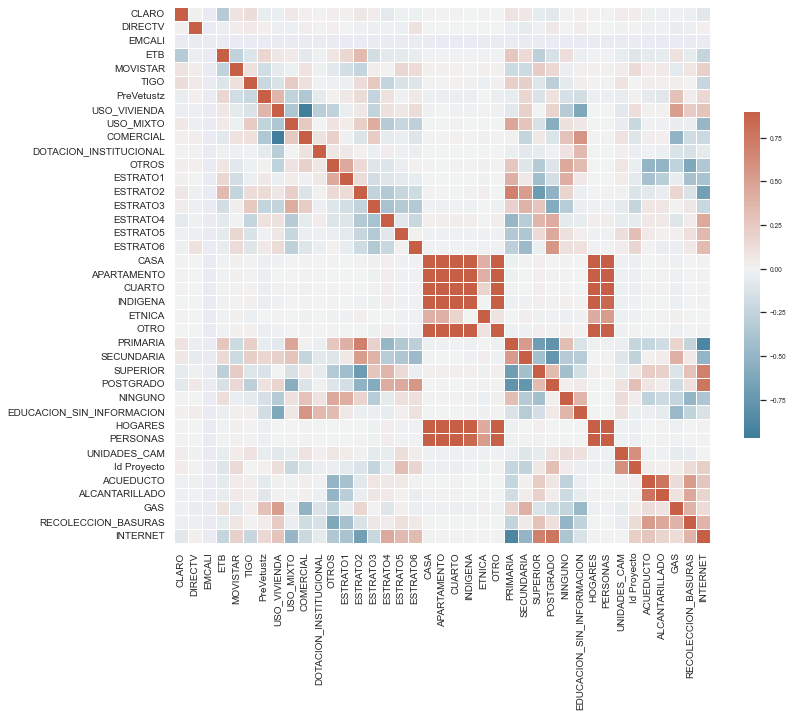

In [63]:
###sns.swarmplot(x=HFC4['ETB_FLAG'],y=HFC4['PreVetustz'])

correlaciones=HFC4.loc[(HFC4.MPIO_CDPMP=="11001") &(HFC4.ETB>0)][['CLARO', 'DIRECTV', 'EMCALI', 'ETB', 'MOVISTAR', 'TIGO', 'PreVetustz',
  'USO_VIVIENDA','USO_MIXTO','COMERCIAL','DOTACION_INSTITUCIONAL','OTROS', 'ESTRATO1', 'ESTRATO2', 'ESTRATO3', 'ESTRATO4','ESTRATO5', 'ESTRATO6',
  'CASA', 'APARTAMENTO', 'CUARTO','INDIGENA', 'ETNICA', 'OTRO', 'PRIMARIA', 'SECUNDARIA', 'SUPERIOR', 'POSTGRADO', 'NINGUNO','EDUCACION_SIN_INFORMACION',
 'HOGARES', 'PERSONAS','UNIDADES_CAM','Id Proyecto','ACUEDUCTO', 'ALCANTARILLADO', 'GAS', 'RECOLECCION_BASURAS', 'INTERNET']].corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.set(font_scale = 0.6)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
sns.heatmap(correlaciones, vmax=.9,center=0,cmap=cmap,square=True, linewidths=.5,annot_kws = {"size": 10}, cbar_kws={"shrink": .5},ax = ax)
ax.tick_params(labelsize = 10)

In [64]:
# guardamos HFC4 como  HFC_Operador_Vetustez.geojson
HFC4.to_file(os.path.join(data_dir, "HFC_Operador_Vetustez.geojson"), driver='GeoJSON', encoding='utf-8')

## Análisis Lisa

In [65]:
######################################
##############Análisis Lisa############
########################################
coords = points_to_coords(HFC4.geometry.centroid)
q_d=weights.DistanceBand(coords, threshold=1/100, binary=False)##Límite en grados 1/200 ~ 555 mt.
q_d.transform='R'

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

There are 63 disconnected observations 
  Island ids: 40, 229, 706, 1052, 2314, 2880, 5583, 7102, 7114, 7115, 7117, 7119, 7145, 7146, 7187, 7241, 7530, 7531, 7635, 7637, 7966, 7969, 8081, 8695, 8770, 8772, 8774, 8776, 8777, 8779, 8780, 8790, 8792, 8944, 10113, 10351, 10401, 10564, 10588, 10594, 11008, 11041, 11057, 11251, 11282, 11818, 12276, 12292, 12293, 12294, 12296, 12297, 12298, 12300, 12302, 12623, 12700, 12701, 12855, 12906, 12914, 12947, 12994


('WARNING: ', 40, ' is an island (no neighbors)')
('WARNING: ', 229, ' is an island (no neighbors)')
('WARNING: ', 706, ' is an island (no neighbors)')
('WARNING: ', 1052, ' is an island (no neighbors)')
('WARNING: ', 2314, ' is an island (no neighbors)')
('WARNING: ', 2880, ' is an island (no neighbors)')
('WARNING: ', 5583, ' is an island (no neighbors)')
('WARNING: ', 7102, ' is an island (no neighbors)')
('WARNING: ', 7114, ' is an island (no neighbors)')
('WARNING: ', 7115, ' is an island (no neighbors)')
('WARNING: ', 7117, ' is an island (no neighbors)')
('WARNING: ', 7119, ' is an island (no neighbors)')
('WARNING: ', 7145, ' is an island (no neighbors)')
('WARNING: ', 7146, ' is an island (no neighbors)')
('WARNING: ', 7187, ' is an island (no neighbors)')
('WARNING: ', 7241, ' is an island (no neighbors)')
('WARNING: ', 7530, ' is an island (no neighbors)')
('WARNING: ', 7531, ' is an island (no neighbors)')
('WARNING: ', 7635, ' is an island (no neighbors)')
('WARNING: ', 76

In [66]:
hasta aqui

SyntaxError: invalid syntax (Temp/ipykernel_1396/121160381.py, line 1)

In [ ]:
HFC4.head(3)

In [ ]:
#Definir variable con rezago espacial
HFC4['w_ETB_FLAG']=weights.spatial_lag.lag_spatial(q_d, HFC4['ETB_FLAG'])
HFC4['w_CLARO_FLAG']=weights.spatial_lag.lag_spatial(q_d, HFC4['CLARO_FLAG'])
HFC4['w_DIRECTV_FLAG']=weights.spatial_lag.lag_spatial(q_d, HFC4['DIRECTV_FLAG'])
HFC4['w_MOVISTAR_FLAG']=weights.spatial_lag.lag_spatial(q_d, HFC4['MOVISTAR_FLAG'])
HFC4['w_TIGO_FLAG']=weights.spatial_lag.lag_spatial(q_d, HFC4['TIGO_FLAG'])
HFC4['w_EMCALI_FLAG']=weights.spatial_lag.lag_spatial(q_d, HFC4['EMCALI_FLAG'])

In [ ]:
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']

In [ ]:
lisa_cuenta = esda.moran.Moran_Local(HFC4['w_ETB_FLAG'], q_d)
labels_cuenta = [q_labels[i-1] for i in lisa_cuenta.q]
HFC4['cl_ETB_FLAG']=labels_cuenta

In [ ]:
lisa_cuenta = esda.moran.Moran_Local(HFC4['w_CLARO_FLAG'], q_d)
labels_cuenta = [q_labels[i-1] for i in lisa_cuenta.q]
HFC4['cl_CLARO_FLAG']=labels_cuenta

In [ ]:
lisa_cuenta = esda.moran.Moran_Local(HFC4['w_DIRECTV_FLAG'], q_d)
labels_cuenta = [q_labels[i-1] for i in lisa_cuenta.q]
HFC4['cl_DIRECTV_FLAG']=labels_cuenta

In [ ]:
lisa_cuenta = esda.moran.Moran_Local(HFC4['w_MOVISTAR_FLAG'], q_d)
labels_cuenta = [q_labels[i-1] for i in lisa_cuenta.q]
HFC4['cl_MOVISTAR_FLAG']=labels_cuenta

In [ ]:
lisa_cuenta = esda.moran.Moran_Local(HFC4['w_TIGO_FLAG'], q_d)
labels_cuenta = [q_labels[i-1] for i in lisa_cuenta.q]
HFC4['cl_TIGO_FLAG']=labels_cuenta


In [ ]:
lisa_cuenta = esda.moran.Moran_Local(HFC4['w_EMCALI_FLAG'], q_d)
labels_cuenta = [q_labels[i-1] for i in lisa_cuenta.q]
HFC4['cl_EMCALI_FLAG']=labels_cuenta

In [ ]:
####Estandarizar las clases
columnas_clases=['cl_ETB_FLAG', 'cl_CLARO_FLAG', 'cl_DIRECTV_FLAG', 'cl_MOVISTAR_FLAG', 'cl_TIGO_FLAG', 'cl_EMCALI_FLAG']
for z in columnas_clases:
    HFC4[z]=HFC4[z].apply(lambda x: 'A-A' if x=='Q1' else ('B-A' if x=='Q2' else ('B-B' if x=='Q3' else 'A-B')) )

HFC4=HFC4.set_index('NODO')

In [ ]:
#######Clustering######
'''Se realiza un clustering para cada operador
se deben crear un clustering para cada operador'''
###Preparación de la base#####
base_num=HFC4[['USO_VIVIENDA', 'USO_MIXTO', 'COMERCIAL', 'DOTACION_INSTITUCIONAL', 'OTROS', 'ESTRATO1', 'ESTRATO2',
               'ESTRATO3', 'ESTRATO4', 'ESTRATO5', 'ESTRATO6', 'ETB', 'MOVISTAR', 'TIGO', 'PRIMARIA', 'SECUNDARIA', 'SUPERIOR', 'POSTGRADO',
               'UNIDADES_CAM', 'INTERNET', 'ETB_FLAG', 'CLARO_FLAG', 'DIRECTV_FLAG', 'EMCALI_FLAG', 'MOVISTAR_FLAG','TIGO_FLAG' ]].copy()

In [ ]:
# Rellenar información de operadores faltantes
base_num['ETB'].fillna(-1,inplace=True)
base_num['TIGO'].fillna(-1,inplace=True)
base_num['MOVISTAR'].fillna(-1,inplace=True)
if modo_ejecucion=='entrenamiento':
    mes_training=[202007,202008,202009, 202010,202011, 202012, 202101,202102, 202103, 202104,202105,202106, 202107]
    mes_testing=[202108, 202109]
elif modo_ejecucion=='predicion':
    mes_training=[202007,202008,202009, 202010,202011, 202012, 202101,202102, 202103, 202104,202105,202106, 202107,202108, 202109]
    mes_testing=[202110, 202111]

In [ ]:
#Llenar faltantes
base_num=base_num.fillna(np.mean(base_num))

In [ ]:
# Convertir en categoria la variable respuesta
base_num['ETB_FLAG']=base_num['ETB_FLAG'].astype('category').cat.codes
base_num['CLARO_FLAG']=base_num['CLARO_FLAG'].astype('category').cat.codes
base_num['DIRECTV_FLAG']=base_num['DIRECTV_FLAG'].astype('category').cat.codes
base_num['EMCALI_FLAG']=base_num['EMCALI_FLAG'].astype('category').cat.codes
base_num['EMCALI_FLAG']=base_num['EMCALI_FLAG'].astype('category').cat.codes

In [ ]:
# Variables independientes
# Lables de columnas
cols_x = base_num[base_num.columns.difference(['ETB_FLAG', 'CLARO_FLAG', 'DIRECTV_FLAG', 'EMCALI_FLAG', 'MOVISTAR_FLAG','TIGO_FLAG'])].columns
X = base_num[base_num.columns.difference(['ETB_FLAG', 'CLARO_FLAG','DIRECTV_FLAG', 'EMCALI_FLAG','MOVISTAR_FLAG','TIGO_FLAG'])].values

In [ ]:
base_num.head(2)

In [ ]:
base_num.shape

In [ ]:
# para ver que tipo de variables tiene las columnas
categori_columna_x=base_num.ETB_FLAG.value_counts()
categori_columna_x

In [ ]:
mes_training.sort()
mes_training

In [ ]:
mes_testing.sort()
mes_testing

## ETB

In [ ]:
#####ETB######
y = base_num['ETB_FLAG'].values
# Dividimos en Train en meses anteriores a junio, Test 2 últimos meses
X_train=X[base_num['ETB'].isin(mes_training)]
X_test=X[base_num['ETB'].isin(mes_testing)]
y_train=y[base_num['ETB'].isin(mes_training)]
y_test=y[base_num['ETB'].isin(mes_testing)]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X[base_num['ETB'].isin([0,-1])], y[base_num['ETB'].isin([0,-1])], test_size=0.5, random_state=1)

X_train_etb=np.concatenate([X_train,X_train2])
y_train_etb=np.concatenate([y_train,y_train2])
X_test_etb=np.concatenate([X_test,X_test2])
y_test_etb=np.concatenate([y_test,y_test2])

In [ ]:
y_para_nuevoetb=base_num[base_num['ETB'].isin(mes_testing)][['ETB']]
y_para_nuevoetb.head()

In [ ]:
y_train_etb.shape

In [ ]:
# Definir el clasificador
nombreModelo = f"C:\\Users\\WilsonAdolfoEstacioR\\Documents\\Expansion_Fija\\2_Script\\dtc_ETB.pkl"
if modo_ejecucion=='entrenamiento':
    dtc_ETB = tree.DecisionTreeClassifier()
    dtc_ETB = dtc_ETB.fit(X_train_etb,y_train_etb)
    # prediccion de X_test_etb
    # y_pred_etb1=y_pred_etb.copy()
    # para guadar el modelo    
    dump(dtc_ETB, nombreModelo)
elif modo_ejecucion=='predicion':
    dtc_ETB=load(nombreModelo)
    
y_pred_etb = dtc_ETB.predict(X_test_etb) 

In [ ]:
#Métricas
if modo_ejecucion=='entrenamiento':
    print("Exactitud:", metrics.accuracy_score(y_test_etb, y_pred_etb)) #0.91   #0.99
    print("Precisión:", metrics.precision_score(y_test_etb, y_pred_etb))    #0.85   #0.86
    print("Recall:", metrics.recall_score(y_test_etb, y_pred_etb))  #0.845      #0.89
    print("F1 Score:", metrics.f1_score(y_test_etb, y_pred_etb)) #0.852     #0.89
    print("ROC AUC Score:", roc_auc_score(y_test_etb, y_pred_etb))  #0.893  #0.94

In [ ]:
from sklearn.metrics import confusion_matrix
if modo_ejecucion=='entrenamiento':
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8,5))
    matrizConfucion = confusion_matrix(y_test_etb, y_pred_etb)
    matrizConfucionDF=pd.DataFrame(matrizConfucion, index=['0','1'], columns=['0','1'])
    sns.heatmap(matrizConfucionDF, annot = True, cmap = 'Greens', fmt='g',annot_kws={"size": 16})
    axes.tick_params(labelsize = 20)
    plt.title('ETB')

In [ ]:
# Calculamos las curvas ROC
from sklearn.metrics import roc_curve
if modo_ejecucion=='entrenamiento':
    ns_probs = [0 for _ in range(len(y_test_etb))]
    # ns_auc = roc_auc_score(y_test, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_test_etb, ns_probs)

    fpr1, tpr1, _ = roc_curve(y_test_etb, y_pred_etb)
    auc1 =roc_auc_score(y_test_etb, y_pred_etb)
    print('ROC AUC', auc1)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
    plt.plot(fpr1, tpr1, marker='.', label='DecisionTreeClassifier')
    # Etiquetas de los ejes
    plt.legend()
    plt.title('ROC ETB')
    plt.show()

In [ ]:
## import shap
# df_x_train_etb=pd.DataFrame(X_train_etb,columns=base_num.columns)
# shap_test = df_x_train_etb
# shap_values = shap.TreeExplainer(dtc_ETB).shap_values(df_x_train_etb)
# plt.figure()
# plt.title('ttt')
# shap.summary_plot(shap_values, shap_test,max_display=30)
# plt.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.3)    
# plt.show();
if modo_ejecucion=='entrenamiento':
    shap_test = X_train_etb
    shap_values = shap.TreeExplainer(dtc_ETB).shap_values(X_train_etb)
    plt.figure()
    plt.title('variables de mas ajuste')
    shap.summary_plot(shap_values, shap_test,max_display=30)
    plt.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.3)    
    plt.show();

In [ ]:
base_num.columns

### MOVISTAR

In [ ]:
#####MOVISTAR######
y = base_num['MOVISTAR_FLAG'].values
X_train=X[base_num['MOVISTAR'].isin(mes_training)]
X_test=X[base_num['MOVISTAR'].isin(mes_testing)]
y_train=y[base_num['MOVISTAR'].isin(mes_training)]
y_test=y[base_num['MOVISTAR'].isin(mes_testing)]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X[base_num['MOVISTAR'].isin([0,-1])], y[base_num['MOVISTAR'].isin([0,-1])], test_size=0.5, random_state=1)
X_train_mov=np.concatenate([X_train,X_train1])
y_train_mov=np.concatenate([y_train,y_train1])
X_test_mov=np.concatenate([X_test,X_test1])
y_test_mov=np.concatenate([y_test,y_test1])

In [ ]:
y_para_nuevomov=base_num[base_num['MOVISTAR'].isin(mes_testing)][['MOVISTAR']]
y_para_nuevomov.head()

In [ ]:
# Definir el clasificador
nombreModelo = f"C:\\Users\\WilsonAdolfoEstacioR\\Documents\\Expansion_Fija\\2_Script\\dtc_movistar.pkl"
if modo_ejecucion=='entrenamiento':
    dtc_movistar = tree.DecisionTreeClassifier()
    dtc_movistar = dtc_movistar.fit(X_train_mov,y_train_mov)
    dump(dtc_movistar, nombreModelo)
elif modo_ejecucion=='predicion':
    dtc_movistar=load(nombreModelo)
    
y_pred_mov = dtc_movistar.predict(X_test_mov)    
y_pred_mov1=y_pred_mov.copy()

In [ ]:
#Métricas
if modo_ejecucion=='entrenamiento':
    print("Exactitud:", metrics.accuracy_score(y_test_mov, y_pred_mov)) #0.8    #0.99
    print("Precisión:", metrics.precision_score(y_test_mov, y_pred_mov))    #0.68   #0.98
    print("Recall:", metrics.recall_score(y_test_mov, y_pred_mov))  #0.64   #0.96
    print("F1 Score:", metrics.f1_score(y_test_mov, y_pred_mov))    #0.66   #0.97
    print("ROC AUC Score:",  roc_auc_score(y_test_mov, y_pred_mov))  #0.75   #0.97

In [ ]:
if modo_ejecucion=='entrenamiento':
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8,5))
    matrizConfucion = confusion_matrix(y_test_mov, y_pred_mov)
    matrizConfucionDF=pd.DataFrame(matrizConfucion, index=['0','1'], columns=['0','1'])
    sns.heatmap(matrizConfucionDF, annot = True, cmap = 'Greens', fmt='g',annot_kws={"size": 16})
    axes.tick_params(labelsize = 10)
    plt.title('Movistar')

In [ ]:
# Calculamos las curvas ROC
from sklearn.metrics import roc_curve
if modo_ejecucion=='entrenamiento':
    ns_probs = [0 for _ in range(len(y_test_mov))]
    # ns_auc = roc_auc_score(y_test, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_test_mov, ns_probs)

    fpr1, tpr1, _ = roc_curve(y_test_mov, y_pred_mov)
    auc1 =roc_auc_score(y_test_mov, y_pred_mov)
    print('ROC AUC', auc1)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
    plt.plot(fpr1, tpr1, marker='.', label='DecisionTreeClassifier')
    # Etiquetas de los ejes
    plt.title('ROC Movistar')
    plt.legend()
    plt.show()

In [ ]:
import shap
if modo_ejecucion=='entrenamiento':
    shap_test = X_train_mov
    shap_values = shap.TreeExplainer(dtc_movistar).shap_values(X_train_mov)
    plt.figure()
    plt.title('ttt')
    shap.summary_plot(shap_values, shap_test,max_display=30)
    plt.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.3)    
    plt.show();

### TIGO

In [ ]:
##### TIGO ######
y = base_num['TIGO_FLAG'].values
X_train=X[base_num['TIGO'].isin(mes_training)]
X_test=X[base_num['TIGO'].isin(mes_testing)]
y_train=y[base_num['TIGO'].isin(mes_training)]
y_test=y[base_num['TIGO'].isin(mes_testing)]
X_train0, X_test0, y_train0, y_test0 = train_test_split(X[base_num['TIGO'].isin([0,-1])], y[base_num['TIGO'].isin([0,-1])], test_size=0.5, random_state=1)
X_train_tigo=np.concatenate([X_train,X_train0])
y_train_tigo=np.concatenate([y_train,y_train0])
X_test_tigo=np.concatenate([X_test,X_test0])
y_test_tigo=np.concatenate([y_test,y_test0])

In [ ]:
y_para_nuevotig=base_num[base_num['TIGO'].isin(mes_testing)][['TIGO']]
y_para_nuevotig.head()

In [ ]:
# Definir el clasificador
nombreModelo = f"C:\\Users\\WilsonAdolfoEstacioR\\Documents\\Expansion_Fija\\2_Script\\dtc_tigo.pkl"
if modo_ejecucion=='entrenamiento':
    dtc_tigo = tree.DecisionTreeClassifier()
    dtc_tigo = dtc_tigo.fit(X_train_tigo,y_train_tigo)
    dump(dtc_tigo, nombreModelo)
elif modo_ejecucion=='predicion':
    dtc_tigo=load(nombreModelo)
y_pred_tigo = dtc_tigo.predict(X_test_tigo)
y_pred_tigo1=y_pred_tigo.copy()

In [ ]:
#Métricas
if modo_ejecucion=='entrenamiento':
    print("Exactitud:", metrics.accuracy_score(y_test_tigo, y_pred_tigo)) #0.745  #0.99
    print("Precisión:", metrics.precision_score(y_test_tigo, y_pred_tigo))    #0.43   #0.97
    print("Recall:", metrics.recall_score(y_test_tigo, y_pred_tigo))  #0.377      #0.97
    print("F1 Score:", metrics.f1_score(y_test_tigo, y_pred_tigo))    #0.4    #0.975
    print("ROC AUC Score:", roc_auc_score(y_test_tigo, y_pred_tigo))  #0.61   0.98

In [ ]:

if modo_ejecucion=='entrenamiento':
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8,5))
    matrizConfucion = confusion_matrix(y_test_tigo, y_pred_tigo)
    matrizConfucionDF=pd.DataFrame(matrizConfucion, index=['0','1'], columns=['0','1'])
    sns.heatmap(matrizConfucionDF, annot = True, cmap = 'Greens', fmt='g',annot_kws={"size": 16})
    axes.tick_params(labelsize = 20)
    plt.title('Tigo')

In [ ]:
# Calculamos las curvas ROC
if modo_ejecucion=='entrenamiento':
    ns_probs = [0 for _ in range(len(y_test_tigo))]
    # ns_auc = roc_auc_score(y_test, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_test_tigo, ns_probs)


    fpr1, tpr1, _ = roc_curve(y_test_tigo, y_pred_tigo)
    auc1 =roc_auc_score(y_test_tigo, y_pred_tigo)
    print('ROC AUC', auc1)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
    plt.plot(fpr1, tpr1, marker='.', label='DecisionTreeClassifier')
    # Etiquetas de los ejes
    plt.title('ROC Tigo')
    plt.legend()
    plt.show()

In [ ]:
if modo_ejecucion=='entrenamiento':
    shap_test = X_train_tigo
    shap_values = shap.TreeExplainer(dtc_tigo).shap_values(X_train_tigo)
    plt.figure()
    plt.title('ttt')
    shap.summary_plot(shap_values, shap_test,max_display=30)
    plt.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.3)    
    plt.show();

In [ ]:
# para guadar el modelo
# from joblib import dump,load
# nombreModelo = f"C:\\Users\\WilsonAdolfoEstacioR\\Documents\\Expansion_Fija\\2_Script\\dtc_movistar.pkl"
# dump(dtc_movistar, nombreModelo)

## Predicciones

In [ ]:
######Predicciones#######
HFC4.loc[HFC4.ETB_FLAG==0, 'PRED_ETB']=dtc_ETB.predict(base_num.loc[base_num.ETB_FLAG==0][cols_x])
HFC4.loc[HFC4.MOVISTAR_FLAG==0, 'PRED_MOVISTAR']=dtc_movistar.predict(base_num.loc[base_num.MOVISTAR_FLAG==0][cols_x])
HFC4.loc[HFC4.TIGO_FLAG==0, 'PRED_TIGO']=dtc_tigo.predict(base_num.loc[base_num.TIGO_FLAG==0][cols_x])

HFC4['PRED_ETB']=HFC4['PRED_ETB'].fillna(2)
HFC4['PRED_MOVISTAR']=HFC4['PRED_MOVISTAR'].fillna(2)
HFC4['PRED_TIGO']=HFC4['PRED_TIGO'].fillna(2)

In [ ]:
####Análisis local espacial de instalaciones recientes
HFC5=HFC4.copy()

## Función lisa

In [ ]:
##Función lisa
def LISA(capa, variable):
    capa["Reciente"]=capa[variable].apply(lambda x: 1 if x>202105 else (0 if x<1 else 2))
    capa=capa.loc[capa.Reciente.isin([1,0])]
    coords = points_to_coords(capa.geometry.centroid)
    q_d = weights.DistanceBand(coords, threshold=1 / 200, binary=False)  ##Límite en grados 1/200 ~ 555 mt.
    q_d.transform = 'R'
        # Definir variable con rezago espacial
    capa['VAR_REZAGO'] = weights.spatial_lag.lag_spatial(q_d, capa["Reciente"])
    q_labels = ['Q1', 'Q2', 'Q3', 'Q4']

    lisa_cuenta = esda.moran.Moran_Local(capa['VAR_REZAGO'], q_d) # moran.Moran_Loca analisis de correlacion 
    labels_cuenta = [q_labels[i - 1] for i in lisa_cuenta.q]
    variable_clase="cl_Rec_"+variable
    capa[variable_clase] = labels_cuenta
    capa[variable_clase] = capa[variable_clase].apply(lambda x: 'A-A' if x == 'Q1' else ('B-A' if x == 'Q2' else ('B-B' if x == 'Q3' else 'A-B')))
    return capa[[variable_clase]]

pd.notnull

### Unir resultados

In [ ]:
### Unir resultados de
HFC5=HFC5.merge(LISA(HFC5.copy(), "ETB"),right_index=True, left_index=True,how="left")
HFC5=HFC5.merge(LISA(HFC5.copy(), "MOVISTAR"),right_index=True, left_index=True,how="left")
HFC5=HFC5.merge(LISA(HFC5.copy(), "TIGO"),right_index=True, left_index=True,how="left")

In [ ]:
### Extracción del resultado
HFC5.to_file(os.path.join(data_dir, "HFC_PREDICCION_NUEVA.geojson"), driver='GeoJSON', encoding='utf-8')

In [ ]:
### Extracción del resultado
HFC5.to_file(os.path.join(result_dir, "HFC_PREDICCION_NUEVA.csv"), encoding='utf-8')

In [ ]:
HFC5.to_csv('C:\\Users\\WilsonAdolfoEstacioR\\Documents\\Expansion_Fija\\3_Resultados\\resultados_pred_nueva.csv', encoding='utf-8',sep=',')

In [ ]:
pd.set_option('display.max_columns', None)
HFC5.head(2)

In [ ]:
categori_ETB=HFC5.cl_Rec_TIGO.value_counts()
categori_ETB

# Categorias por Variable a predecir

In [ ]:
categori_ETB=HFC5.ETB.value_counts()
categori_ETB

In [ ]:
categori_MOVISTAR=HFC5.MOVISTAR.value_counts(ascending=False)
categori_MOVISTAR

In [ ]:
categori_TIGO=HFC5.TIGO.value_counts()
categori_TIGO

In [ ]:
HFC5.shape

In [ ]:
HFC5.crs

In [ ]:
# HFC5.explore("cl_Rec_ETB", legend=False)
# pip install xarray

In [ ]:

# import geoviews as gv
# import geoviews.feature as gf
# import xarray as xr
# from cartopy import crs

# gv.Polygons(gpd.read_file(gpd.HFC5.get_path('w_EMCALI_FLAG')), vdims=['pop_est', ('name', 'Country')]).opts(
#     tools=['hover'], width=600, projection=crs.Robinson()
# ) # small_areas_points

In [ ]:
# gv.Polygons(gpd.read_file(gpd.HFC5.get_path('naturalearth_lowres')), vdims=['pop_est', ('name', 'Country')]).opts(
#     tools=['hover'], width=600, projection=crs.Robinson()

In [ ]:
HFC5_M=HFC5.copy()
HFC5_M=HFC5_M.to_crs({'init':'epsg:3857'}) # Copio GeoDataFrame y cambio la proyección a un sistema cartesiano (EPSG:3857,unidad=m)
print(HFC5_M).crstost.head(2)

In [ ]:
# https://sisteme-ig.com/questions/5180/obtener-areas-de-poligonos-usando-geopandas
# area de cada poligono   (devuelta en m ^ 2)
HFC5_M["area"] = HFC5_M['geometry'].area/10**6  # Ahora el area en km^2
HFC5_M.head(2)

In [ ]:
# # https://sisteme-ig.com/questions/5180/obtener-areas-de-poligonos-usando-geopandas
# # area de cada poligono   (devuelta en m ^ 2)
# HFC5_M["area"] = HFC5_M['geometry'].area
# HFC5_M.head(2)

In [ ]:
HFC5_M.crs

In [ ]:
# # zonas de interes etb
# ocupacion__ETB = HFC5_M[(HFC5_M['ETB'] > 1)]

# fechas = [202008,202009,202010,202011,202012,202101,202102,202103,202104,202105,202106,202107,202108,202109]
# for i in fechas:
#     ocupacion_E=ocupacion__ETB[ocupacion__ETB['ETB']==i]
#     suma=ocupacion_E['area'].sum()
#     print(suma)

In [ ]:
# zonas de interes etb
HFC4_ETB = HFC5_M[(HFC5_M['ETB'] < 1) & (HFC5_M['cl_ETB_FLAG'] == "A-A")]
HFC4_ETB.shape

In [ ]:
# zonas de interes movistar
HFC4_MOVISTAR = HFC5_M[(HFC5_M['MOVISTAR'] < 1) & (HFC5_M['cl_Rec_MOVISTAR'] == "A-A")]
HFC4_MOVISTAR.shape

In [ ]:
# zonas de interes tigo
HFC4_TIGO = HFC5_M[(HFC5_M['TIGO'] < 1) & (HFC5_M['cl_Rec_TIGO'] == "A-A")]
HFC4_TIGO.shape

In [ ]:
# HFC5_movistar=HFC5[HFC5['MOVISTAR']== -1]
# HFC5_movistar=HFC5_M.loc[(HFC5_M[HFC5_M['MOVISTAR']== -1]) | (HFC5_M[HFC5_M['MOVISTAR']== 0])]
# HFC5_movistar

## Estadística de crecimiento reciente

In [ ]:
HFC5['cl_Rec_TIGO'].value_counts()

In [ ]:
HFC5['cl_Rec_ETB'].value_counts()

In [ ]:
#####Estadística de crecimiento reciente
HFC5['cl_Rec_MOVISTAR'].value_counts()

In [ ]:
HFC5.loc[HFC5.ETB>0] ###4185 ETB tienen fibra 4513
# HFC5.loc[HFC5.MOVISTAR>0] ###4157 Movistar tienen fibra 5906
# HFC5.loc[HFC5.TIGO>0] ### 2999 tigo tienen fibra 5839

# Estadísticas de predicción

In [ ]:
#####Estadísticas de predicción
HFC5.PRED_MOVISTAR.value_counts()

In [ ]:
HFC5.PRED_ETB.value_counts()

In [ ]:
HFC5.PRED_TIGO.value_counts()

In [ ]:
### Intersección de resultados de ambas alternativas
HFC5.loc[(HFC5.PRED_MOVISTAR==1) &(HFC5.cl_Rec_MOVISTAR=="A-A")]
HFC5.loc[(HFC5.PRED_ETB==1) &(HFC5.cl_Rec_ETB=="A-A")]
HFC5.loc[(HFC5.PRED_TIGO==1) &(HFC5.cl_Rec_TIGO=="A-A")]

In [ ]:
##### Intersección con cobertura Claro
HFC5.loc[(HFC5.PRED_MOVISTAR==1) &(HFC5.cl_Rec_MOVISTAR=="B-A") & (HFC5.CLARO<1)]
HFC5.loc[(HFC5.PRED_ETB==1) &(HFC5.cl_Rec_ETB=="B-A")& (HFC5.CLARO<1)]
HFC5.loc[(HFC5.PRED_TIGO==1) &(HFC5.cl_Rec_TIGO=="B-A")& (HFC5.CLARO<1)]

In [ ]:
HFC5_M.head(2)

# Hectáreas por mensual conquistado por operadores

In [ ]:
# zonas de interes etb
ocupacion__ETB = HFC5_M[(HFC5_M['ETB'] > 1)]

fechas = [202008,202009,202010,202011,202012,202101,202102,202103,202104,202105,202106,202107,202108,202109]
for i in fechas:
    ocupacion_E=ocupacion__ETB[ocupacion__ETB['ETB']==i]
    suma=ocupacion_E['area'].sum()
    print(suma)

In [ ]:
ocupacion_MOVISTAR = HFC5_M[(HFC5_M['MOVISTAR'] > 1)]
for i in fechas:
    ocupacion_M=ocupacion_MOVISTAR[ocupacion_MOVISTAR['MOVISTAR']==i]
    suma=ocupacion_M['area'].sum()
    print(suma)

In [ ]:
ocupacion_TIGO = HFC5_M[(HFC5_M['TIGO'] > 1)]
for i in fechas:
    ocupacion_T=ocupacion_TIGO[ocupacion_TIGO['TIGO']==i]
    suma=ocupacion_T['area'].sum()
    print(suma)

In [ ]:
ocupacion_nodo=pd.read_csv(os.path.join(data_dir, "resultadosOcupacionNodos (oct21_mar22).csv"),sep=";", parse_dates=True)
ocupacion_nodo.head(2)

In [ ]:
ocupacion_nodo=ocupacion_nodo.loc[:, [ 'NODO', 'oct_pred_cont_M1', 'oct_21_Ranking',
                                 'nov_21_pred_cont_M1', 'nov_21_Ranking',
                                 'dic_21_pred_cont_M1', 'dic_21_Ranking',
                                 'ene_22_pred_cont_M1', 'ene_22_Ranking',]]

In [ ]:
ocupacion_nodo

In [ ]:
ocupacion_nodo.set_index('NODO', inplace = True)

In [ ]:
#  uno las tablas de ocupacion nodo y de predicion ftth osea HFC5_M
ocupacion_y_HFC5=HFC5_M.merge(ocupacion_nodo, left_on="NODO", right_index=True, how="left")

In [ ]:
ocupacion_y_HFC5.to_file(os.path.join(result_dir, "ocupacion_y_HFC5.csv"), encoding='utf-8')

In [ ]:
ocupacion_y_HFC5.to_csv('C:\\Users\\WilsonAdolfoEstacioR\\Documents\\Expansion_Fija\\3_Resultados\\resultadosVpyVn_nuevos.csv', encoding='utf-8',sep=',')

In [ ]:
ocupacion_y_HFC5.head(4)

In [ ]:
ocupacion_y_HFC5.shape

In [ ]:
# ocupacion_nodoAB = ocupacion_y_HFC5_M[(ocupacion_y_HFC5_M['oct_pred_cont_M1'] >=0.6) & (ocupacion_y_HFC5_M['nov_21_pred_cont_M1'] >=0.6) & (ocupacion_y_HFC5_M['dic_21_pred_cont_M1'] >=0.6) ]
# ocupacion_nodoAB.head()
# ocupacion_y_HFC5.head(2)

In [ ]:
# puntuacion
ocupacion_y_HFC5['cl_Rec_ETB_score'] = ocupacion_y_HFC5['cl_Rec_ETB'].map({'A-A':1 ,'A-B': 0.6, 'B-A':0.4, 'B-B': 0.2})
ocupacion_y_HFC5['cl_Rec_MOVISTAR_score'] = ocupacion_y_HFC5['cl_Rec_MOVISTAR'].map({'A-A':1 ,'A-B': 0.6, 'B-A':0.4, 'B-B': 0.2}) 
ocupacion_y_HFC5['cl_Rec_TIGO_score'] = ocupacion_y_HFC5['cl_Rec_TIGO'].map({'A-A':1 ,'A-B': 0.6, 'B-A':0.4, 'B-B': 0.2}) 

In [ ]:
ocupacion_y_HFC5.head(2)

# Nodos que cumplen la intersecion de AA

In [ ]:
# nodos que cumplen la intersecion
intersecionAA=ocupacion_y_HFC5.loc[(ocupacion_y_HFC5.cl_Rec_ETB=="A-A") & (ocupacion_y_HFC5.cl_Rec_MOVISTAR=="A-A") & (ocupacion_y_HFC5.cl_Rec_TIGO=="A-A")]
intersecionAA.shape

In [ ]:
intersecionAA_tigo= intersecionAA[(intersecionAA['ETB'] < 1)]
intersecionAA_tigo.shape

In [ ]:
intersecionAA_tigo_R=intersecionAA_tigo[(ocupacion_y_HFC5['nov_21_Ranking'] >= 0.6)]
intersecionAA_tigo_R.shape

In [ ]:
intersecionAB=ocupacion_y_HFC5.loc[(ocupacion_y_HFC5.cl_Rec_ETB=="B-A") &(ocupacion_y_HFC5.cl_Rec_MOVISTAR=="B-A") & (ocupacion_y_HFC5.cl_Rec_TIGO=="B-A")]
intersecionAB.shape

In [ ]:
# nodos que cumplen la intersecion
intersecionAA=ocupacion_y_HFC5.loc[(ocupacion_y_HFC5.PRED_ETB==0) &(ocupacion_y_HFC5.PRED_MOVISTAR==0) & (ocupacion_y_HFC5.PRED_TIGO==0)]
intersecionAA.shape

In [ ]:
intersecion_ranquin= ocupacion_y_HFC5[(ocupacion_y_HFC5['nov_21_Ranking']  >= 0.6)]
intersecion_ranquin.shape

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.distplot(
    ocupacion_y_HFC5.cl_Rec_TIGO_score,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('precio', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.distplot(
    np.sqrt(ocupacion_y_HFC5.cl_Rec_TIGO_score),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(precio)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.distplot(
    np.log(ocupacion_y_HFC5.cl_Rec_TIGO_score),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(precio)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

## Filtramos cada operador para ver cuales tienen ocupacion mayor o igual a 0.6 y que ademas tienen alta probabilidad de expancion

In [ ]:
ocupacion_y_HFC5_M_ETB = ocupacion_y_HFC5[(ocupacion_y_HFC5['ETB'] < 1) & (ocupacion_y_HFC5['cl_Rec_ETB'] == "A-A") & (ocupacion_y_HFC5['nov_21_Ranking'] >= 0.6)]
ocupacion_y_HFC5_M_ETB.shape

In [ ]:
ocupacion_y_HFC5_M_MOVISTAR = ocupacion_y_HFC5[(ocupacion_y_HFC5['MOVISTAR'] < 1) & (ocupacion_y_HFC5['cl_Rec_MOVISTAR'] == "A-A") & (ocupacion_y_HFC5['nov_21_Ranking'] >= 0.6)]
ocupacion_y_HFC5_M_MOVISTAR.shape

In [ ]:
ocupacion_y_HFC5_M_TIGO = ocupacion_y_HFC5[(ocupacion_y_HFC5['TIGO'] < 1) & (ocupacion_y_HFC5['cl_Rec_TIGO'] == "A-A") & (ocupacion_y_HFC5['nov_21_Ranking'] >= 0.6)]
ocupacion_y_HFC5_M_TIGO.shape

# geopandas

In [ ]:
# import contextily as ctx
import folium
from folium.plugins import HeatMap, HeatMapWithTime

ocupacion_y_HFC5.plot(column='ESTRATO6', figsize=(12,10),legend=True);
# ocupacion_y_HFC5.plot(column='ESTRATO6', cmap="Blues", legend=True );

In [ ]:
ocupacion_y_HFC5.plot("area", legend=True)

In [ ]:
ocupacion_y_HFC5.explore()

In [ ]:
# conflicts_projected = ocupacion_y_HFC5.to_crs(epsg=3395)
# fig, ax = plt.subplots()
# conflicts_projected.plot(ax=ax)
# conflicts_projected.plot(ax=ax, color='red')

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(20,18))
# ocupacion_y_HFC5.plot(column='cl_Rec_ETB', cmap="YlGn",k=6, legend=True, figsize=(20,18));
# ax[0].set_title("Normalized Choropleth Map")

# con esto cambiamos de geometiria a puntos
small_areas_points = ocupacion_y_HFC5.copy()
small_areas_points['geometry'] = small_areas_points['geometry'].centroid
small_areas_points.head()

In [ ]:
# small_areas_points.plot(color="grey");

In [ ]:
# operador = ['ETB', 'MOVISTAR', 'TIGO']
# fechas = [202008,202009,202010,202011,202012,202101,202102,202103,202104,202105,202106,202107,202108,202109]
# for var in operador:
#     for i in fechas:
#         nombre_dataframe='ocupacion_y_HFC5_M_'+var
#         print(nombre_dataframe)
#         nombrecampo = "'"+var+"'"
#         print(nombrecampo)
#         ocupacion_y_HFC5_M=nombre_dataframe[nombre_dataframe[nombrecampo]==i] #[nombre_dataframe[nombrecampo]]
#         suma=ocupacion_y_HFC5_M['area'].sum()     

In [ ]:
# Marker Cluster
from folium.plugins import FastMarkerCluster
cmap = folium.Map(location=[4.546647, 22.373178],
                        zoom_start=2,
                        tiles='CartoDB dark_matter')


FastMarkerCluster(data=list(zip(small_areas_points.geometry.y.values, small_areas_points.geometry.x.values))).add_to(cmap)
folium.LayerControl().add_to(cmap)
cmap

In [ ]:
# Marker Cluster
from folium.plugins import FastMarkerCluster
cmap = folium.Map(location=[4.546647, 22.373178],
                        zoom_start=2,
                        tiles='CartoDB dark_matter')


FastMarkerCluster(data=list(zip(small_areas_points.geometry.y.values, small_areas_points.geometry.x.values))).add_to(cmap)
folium.LayerControl().add_to(cmap)
cmap